In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
import cv2

import sys
BASE_PATH = pathlib.Path('..')
sys.path.append(BASE_PATH.name)

import common.loss_utils as loss_utils
import common.utils as utils
import common.checkpointing as checkpointing
import common.denoiser as denoiser

sys.path.append('./dgmr-oneshot-multichannel')
import dgmr

/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
FORECAST = 24
INPUT_STEPS = 4
BATCH_SIZE = 16
FOLDER = pathlib.Path('weights/dgmr_oneshot_optflow')


In [5]:
p = BASE_PATH / 'data/test.npz'
f = np.load(p)
times = f['times']
data = f['data']

In [6]:
times.shape, data.shape

((2189,), (2189, 325, 400))

In [7]:
_MEAN_PIXEL = 240.3414
_STD_PIXEL = 146.52366

# separately calculated by looking at a lot of flows and averaging
_MEAN_X_FLOW = -1.468137
_STD_X_FLOW = 2.535055

_MEAN_Y_FLOW = 0.200738
_STD_Y_FLOW = 1.133198

torch.manual_seed(7)
tsfm = transforms.Compose([
    transforms.Normalize(_MEAN_PIXEL, _STD_PIXEL),
])

In [14]:
# paste the dataloader used by the experiment you are testing
# BUT, you need to make it deterministic. see the comments to see how to do that
# yeah this should probably be better...

test_params = {
    "pyr_scale": 0.5,
    "levels": 2,
    "winsize": 40,
    "iterations": 3,
    "poly_n": 5,
    "poly_sigma": 0.7,
}

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, shuffle=True, random_state=7):
        self.times = times
        self.data = data
        self.generator = np.random.RandomState(random_state)
        self.indices = np.arange(len(self.times) - 35)
        if shuffle:
            self.generator.shuffle(self.indices)
        # we fix the crops ahead of time so fetching an index gives the same image every time
        # during training we wanted different crops each fetch so we did not do this
        self.index_to_randx = [self.generator.randint(0, data.shape[2] - 128) for _ in range(len(self.indices))]
        self.index_to_randy = [self.generator.randint(0, data.shape[1] - 128) for _ in range(len(self.indices))]
        
    def _get_crop(self, index, data):
        # roughly over the mainland UK
        # going determinstic for repeatable experiments
        rand_x = self.index_to_randx[index] # self.generator.randint(0, input_slice.shape[2] - 128)
        rand_y = self.index_to_randy[index] # self.generator.randint(0, input_slice.shape[1] - 128)
        
        # make a data selection
        return data[:, rand_y : rand_y + 128, rand_x : rand_x + 128]

    def __getitem__(self, i):
        index = self.indices[i]
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not utils.check_times(tstart, tend):
            return self.__getitem__((i + 35) % len(self))
        all_data = self.data[index:index+INPUT_STEPS+24]
        all_data = self._get_crop(index, all_data)
        flow = cv2.calcOpticalFlowFarneback(
            prev=all_data[INPUT_STEPS],
            next=all_data[INPUT_STEPS-1],
            flow=None,
            **test_params,
            flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN
        )
        flow = -flow
        xflow = (flow[:,:,0] - _MEAN_X_FLOW) / _STD_X_FLOW
        yflow = (flow[:,:,1] - _MEAN_Y_FLOW) / _STD_Y_FLOW
        all_data = (all_data - _MEAN_PIXEL) / _STD_PIXEL
        
        xflow = torch.FloatTensor(xflow)
        yflow = torch.FloatTensor(yflow)
        x = torch.FloatTensor(all_data[:INPUT_STEPS])
        y = torch.FloatTensor(all_data[INPUT_STEPS:])
        
        # adds a satellite dimension
        x = torch.unsqueeze(x, axis=1)
        y = torch.unsqueeze(y, axis=1)
        
        # expand these for concatenation with x
        xflow = torch.tile(xflow, (INPUT_STEPS, 1, 1, 1))
        yflow = torch.tile(yflow, (INPUT_STEPS, 1, 1, 1))
        
        # concatenate with x
        x = torch.cat([x, xflow, yflow], dim=1)
        
        return x, y

    def __len__(self):
        return len(self.times) - 35

# shuffle the dataset but not dataloader
ds = CustomTensorDataset(times, data)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=False,
    batch_size=BATCH_SIZE,
    num_workers=4,
    prefetch_factor=4
)

In [15]:
x, y = ds[0]

In [16]:
x.shape, y.shape

(torch.Size([4, 3, 128, 128]), torch.Size([24, 1, 128, 128]))

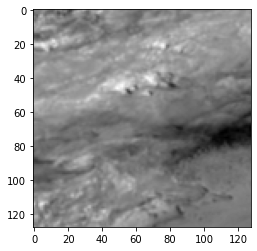

In [17]:
plt.imshow(x[-1,0], cmap='gray')

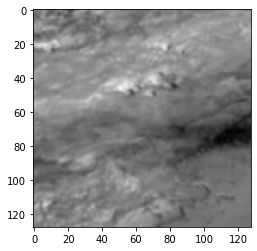

In [18]:
plt.imshow(y[0,0], cmap='gray')

In [19]:
INPUT_CHANNELS = 3

chptr = checkpointing.Checkpointer(FOLDER)

checkpoint, best_epoch = chptr.load_checkpoint()

ccs = dgmr.common.ContextConditioningStack(
    input_channels=INPUT_CHANNELS,
    conv_type='standard',
    output_channels=160,
)

sampler = dgmr.generators.Sampler(
    forecast_steps=FORECAST,
    latent_channels=96,
    context_channels=160*INPUT_CHANNELS,
    output_channels=1,
)

model = dgmr.generators.Generator(ccs, sampler)
if checkpoint is not None:
    print(f'Loading model epoch {best_epoch}')
    model.load_state_dict(checkpoint['model'])
model = model.to(DEVICE)

print(f'The model has {utils.count_parameters(model)} trainable parameters')

# holding this in memory now is a waste
if checkpoint is not None:
    del checkpoint
    torch.cuda.empty_cache()
    

Loading model epoch 86
The model has 242523582 trainable parameters


In [21]:
preds.shape

torch.Size([16, 24, 1, 128, 128])

In [23]:
# for some reason, even in eval mode it is better to keep DGMR in train mode
# if I don't, the loss increases by around 0.02-0.03
model.train()
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=24)

scores_unet = []
scores_flow = []
scores_pers = []
running_total = 0
running_count = 0
pbar = tqdm.tqdm(dl)

test_params = {
    "pyr_scale": 0.5,
    "levels": 2,
    "winsize": 40,
    "iterations": 3,
    "poly_n": 5,
    "poly_sigma": 0.7,
}

# uncomment this if you want to use the denoiser
dn = None # denoiser.Denoiser(DEVICE)

LOOKS = 63
all_preds = []
for i, (srcs, trgs) in enumerate(pbar):
    x = srcs.to(DEVICE)
    y = trgs.to(DEVICE)
    if i > LOOKS:
        break

    # UNET
    with torch.no_grad():
        preds = model(x) * _STD_PIXEL + _MEAN_PIXEL
        # now unnormalize y/x cause we don't need them norm'd anymore
        y = y * _STD_PIXEL + _MEAN_PIXEL
        x = x * _STD_PIXEL + _MEAN_PIXEL
        preds = preds.squeeze(dim=2)
        if dn is not None:
            preds = dn.denoise(preds)
    
    all_preds.append(preds.detach().cpu().numpy())
    
    # remove dimension because we have 1-D images
    preds = torch.squeeze(preds, dim=2)
    y = torch.squeeze(y, dim=2)
    score = utils.get_msssim(preds, y, average=False)
    score = score.detach().cpu().numpy()
    scores_unet.append(score)
    
    running_total += np.mean(score)
    running_count += 1
    
    # FLOW
    ycrop = y[:,:,32:96,32:96]
    batch_flow_scores = np.zeros((len(x), 24), dtype=np.float32)
    for b in range(len(x)):
        flow = cv2.calcOpticalFlowFarneback(
            prev=x[b,-1,0].detach().cpu().numpy(),
            next=x[b,-2,0].detach().cpu().numpy(),
            flow=None,
            **test_params,
            flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
        )
        flow = -flow
        start = x[b,-1,0].detach().cpu().numpy().astype(np.float32)
        preds = np.zeros((24, 64, 64), dtype=np.float32)
        for j in range(24):
            img = utils.warp_flow(start, flow*(j+1))
            preds[j] = img[32:96,32:96]
        preds = torch.FloatTensor(preds).to(DEVICE)
        score = utils.get_msssim(preds, ycrop[b], average=False, inner_64=False)
        score = score.detach().cpu().numpy()
        batch_flow_scores[b] = score
    scores_flow.append(batch_flow_scores)
        
    # PERSISTENCE
    # grab the last image and tile it as the prediction
    preds = torch.tile(x[:,-1:,0], (1,24,1,1))
    score = utils.get_msssim(preds, y, average=False)
    score = score.detach().cpu().numpy()
    scores_pers.append(score)
    
    pbar.set_description(f'Avg Score: {running_total/running_count}')

    

Avg Score: 0.8328741081058979:  47%|████▋     | 64/135 [00:18<00:20,  3.41it/s]


In [24]:
all_preds = np.concatenate(all_preds, axis=0)
scores_unet = np.concatenate(scores_unet, axis=0)
scores_flow = np.concatenate(scores_flow, axis=0)
scores_pers = np.concatenate(scores_pers, axis=0)

In [25]:
all_preds.shape, scores_unet.shape, scores_flow.shape, scores_pers.shape

((1024, 24, 128, 128), (1024, 24), (1024, 24), (1024, 24))

In [26]:
# get per-timestep scores
mean_unet = scores_unet.mean(axis=0)
mean_flow = scores_flow.mean(axis=0)
mean_pers = scores_pers.mean(axis=0)

Text(0, 0.5, 'MS-SSIM')

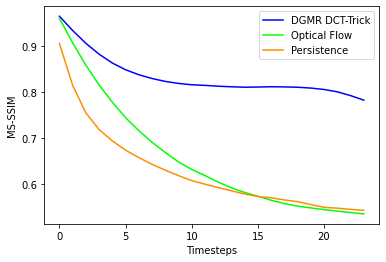

In [27]:
x = np.arange(24)
plt.plot(x, mean_unet, label='DGMR DCT-Trick', color='blue')
plt.plot(x, mean_flow, label='Optical Flow', color='lime')
plt.plot(x, mean_pers, label='Persistence', color='darkorange')
plt.legend()
plt.xlabel('Timesteps')
plt.ylabel('MS-SSIM')

In [28]:
plt.rc('animation', html='jshtml')
from matplotlib import animation


def plot_animation(input_images, images, model_images):
    fig, (ax_true, ax_flow, ax_dgmr) = plt.subplots(1, 3, figsize=(15,15))
    plt.tight_layout()
    plt.close() # Prevents extra axes being plotted below animation

    img_true = ax_true.imshow(images[0], cmap='gray')
    img_dgmr = ax_dgmr.imshow(model_images[0], cmap='gray')
    img_flow = ax_flow.imshow(input_images[0], cmap='gray')
    
    test_params = {
        "pyr_scale": 0.5,
        "levels": 2,
        "winsize": 40,
        "iterations": 3,
        "poly_n": 5,
        "poly_sigma": 0.7,
    }
    flow = cv2.calcOpticalFlowFarneback(
        prev=input_images[-1],
        next=input_images[-2],
        flow=None,
        **test_params,
        flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN,
    )
    flow = -flow
    base_flow_img = input_images[-1].astype(np.float32)

    def animate(i):
        nonlocal images, model_images
        ref = images[i]
        pred_img = model_images[i]
        flow_img = utils.warp_flow(base_flow_img, flow*(i+1))
        pers_img = input_images[-1]
        
        pers_score = utils.get_msssim(pers_img, ref)
        pred_score = utils.get_msssim(pred_img, ref)
        flow_score = utils.get_msssim(flow_img, ref)
        
        ax_true.title.set_text(f'Step {i} Ground Truth. Persistence MS-SSIM: {pers_score:.5f}')
        ax_flow.title.set_text(f'Step {i} Optical Flow MS-SSIM: {flow_score:.5f}')
        ax_dgmr.title.set_text(f'Step {i} UNET MS-SSIM: {pred_score:.5f}')
        return img_true.set_data(images[i]), img_flow.set_data(flow_img), img_dgmr.set_data(pred_img)

    return animation.FuncAnimation(fig, animate, frames=images.shape[0], interval=1000, blit=False)


In [29]:
idx = 2
x, y = ds[idx]
x = x[:,0]
y = y[:,0]
x = x * _STD_PIXEL + _MEAN_PIXEL
y = y * _STD_PIXEL + _MEAN_PIXEL
x = x.numpy()
y = y.numpy()
anim = plot_animation(x, y, all_preds[idx])
anim

In [30]:
import matplotlib.animation as animation
writergif = animation.PillowWriter(fps=3) 
anim.save('model_predictions.gif', writer=writergif)